# Time Series - Part 1

In [17]:
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt
import os

### Plotting helper functions

In [51]:
def plot_series(df, xlabel=None, ylabel=None, plot_title=''):
    fig = go.Figure()
    
    fig.add_trace(go.Scatter(x = df.index, y=df.series,
                             mode='lines', name='Test'))
    xlabel = xlabel if xlabel else 'Time'
    ylabel = ylabel if ylabel else ''
    
    fig.update_layout(xaxis_title=xlabel,
                     yaxis_title=ylabel,
                     template='plotly_dark',
                     title=plot_title 
                     )
    
    fig.show()
    

## Generating time sequence data

In [7]:
def generate_series(length):
    df = pd.DataFrame(0, index=np.arange(0, length), columns=['series']) 
    df.index.name = 'time'
    return df

def white_noise(df, mu=0, sigma=1):
    df.series += sigma * np.random.randn(df.series.shape[0]) + mu
    return df

def trend(df, slope=1/365):
    df.series += slope * df.index
    return df

def seasonality(df, period=100, offset=0, scale=1):
    # Random periodic function
    f = lambda x: np.sin(x) + 1/6 * np.sin(2 * x) - 1/3 *  np.sin(3 * x)
    time = scale * f(2 * np.pi / period * df.index + offset)
    df.series += time 
    return df
    

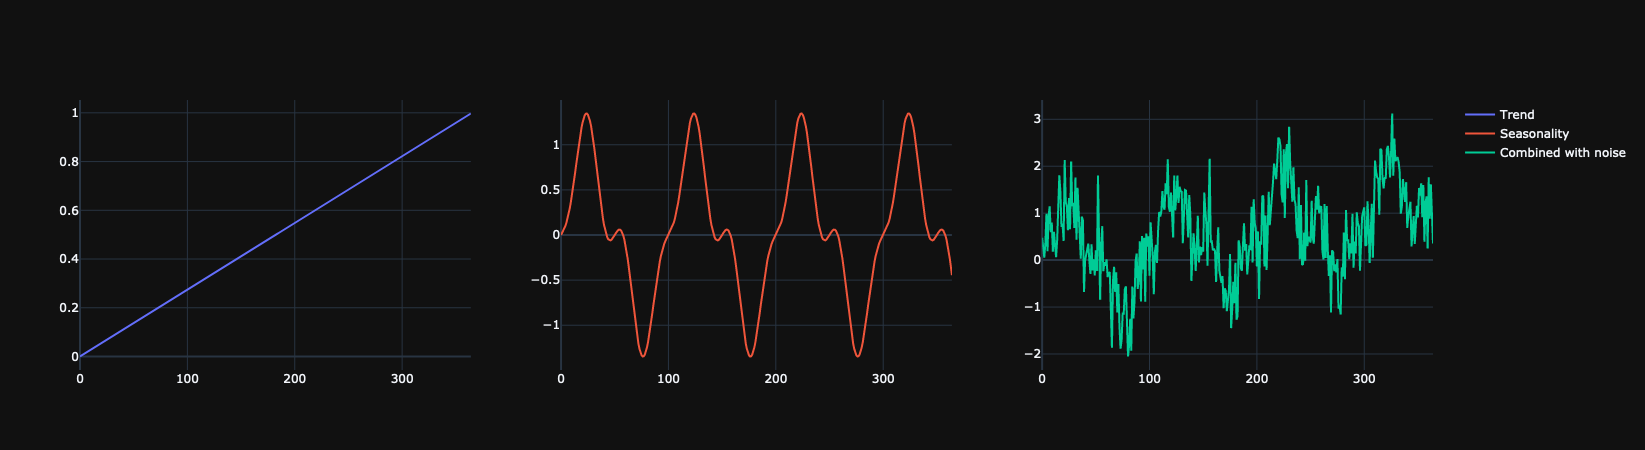

In [16]:
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=3)

trend_series = trend(generate_series(365))
season_series = seasonality(generate_series(365))
combined_series = white_noise(seasonality(trend(generate_series(365))), sigma=0.5)

fig.add_trace(go.Scatter(x=trend_series.index, 
                         y=trend_series.series,
                         name='Trend'
                        ),
                         row=1,
                         col=1,
             )
                                          
             

fig.add_trace(go.Scatter(x=season_series.index, 
                         y=season_series.series,
                         name='Seasonality'
                        ),
                         row=1,
                         col=2,
             ) 
             

fig.add_trace(go.Scatter(x=combined_series.index, 
                         y=combined_series.series,
                         name='Combined with noise'
                        ),
                         row=1,
                         col=3,
             ) 

fig.update_layout(template='plotly_dark')


## Real life time sequence data

COVID-19 data

In [18]:
COVID_DATA_URL = 'https://raw.githubusercontent.com/datasets/covid-19/master/data/worldwide-aggregated.csv'
covid_data = pd.read_csv(COVID_DATA_URL, index_col=0, parse_dates=True)
covid_data.head()

,Confirmed,Recovered,Deaths,Increase rate
Date,,,,
2020-01-22,555,28,17,NaN
2020-01-23,654,30,18,17.837838
2020-01-24,941,36,26,43.883792
2020-01-25,1434,39,42,52.391073
2020-01-26,2118,52,56,47.698745


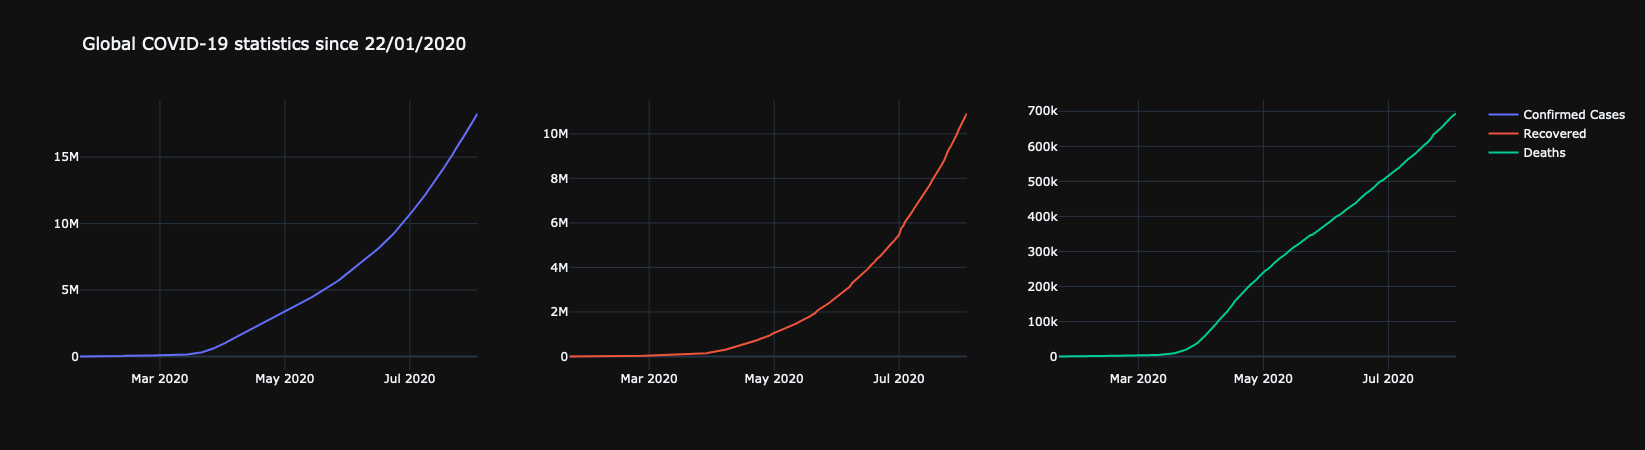

In [21]:
fig = make_subplots(rows=1, cols=3)

fig.add_trace(go.Scatter(x=covid_data.index, 
                         y=covid_data.Confirmed,
                         name='Confirmed Cases'
                        ),
                         row=1,
                         col=1,
             )
                                          
             

fig.add_trace(go.Scatter(x=covid_data.index, 
                         y=covid_data.Recovered,
                         name='Recovered'
                        ),
                         row=1,
                         col=2,
             ) 
             

fig.add_trace(go.Scatter(x=covid_data.index, 
                         y=covid_data.Deaths,
                         name='Deaths'
                        ),
                         row=1,
                         col=3,
             ) 

fig.update_layout(template='plotly_dark',
                  title='Global COVID-19 statistics since 22/01/2020'
                 )


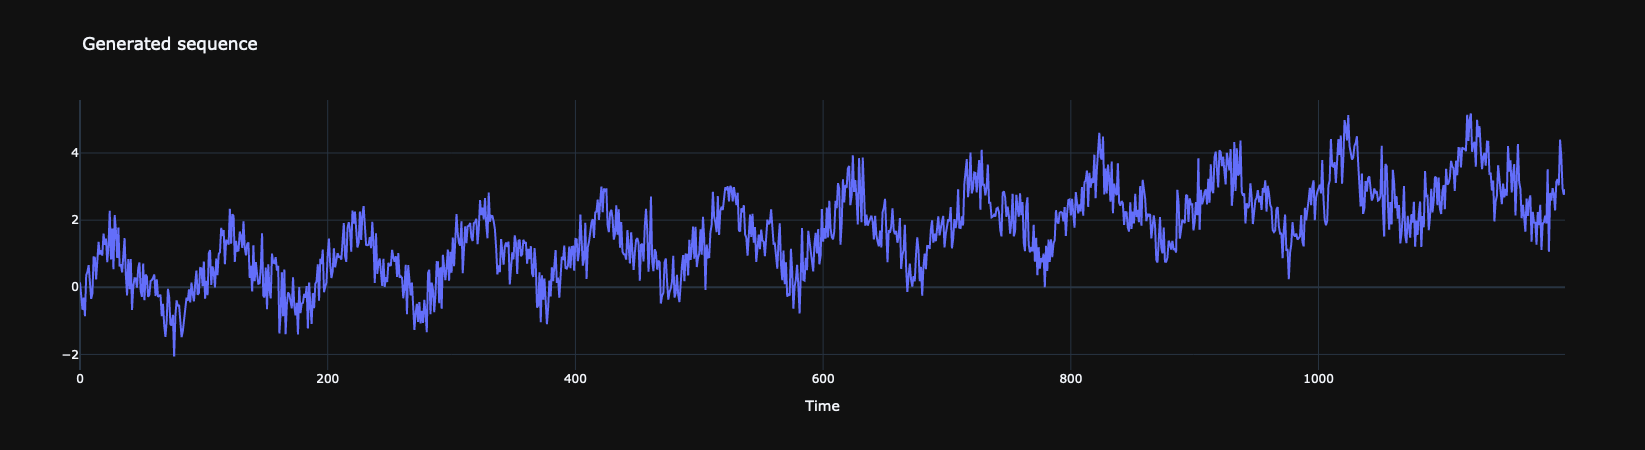

In [36]:
example_series = white_noise(seasonality(trend(generate_series(1200))), sigma=0.5)
plot_series(example_series, plot_title='')

In [25]:
import tensorflow as tf
import keras 
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense

We set up the helper function that will slice up the time series into features and labels. This practically means that n time steps are being used as features to predict the n+1 time step (the label).
Conveniently, this is taken care of by the TimeseriesGenerator from the Keras library.

In [94]:
def prepare_data(series, look_back=10, batch_size=1):
    return TimeseriesGenerator(series, series, length=look_back, batch_size=batch_size)

def train_test_split(df, train_share=0.8):
    n = int(df.shape[0] * train_share)
    data = df.series.to_numpy().reshape((-1,1))
    train_data = data[:n]
    test_data = data[n:]
    train_index = df.index[:n].to_numpy()
    test_index = df.index[n:].to_numpy()
    return train_data, train_index, test_data, test_index
    

In [95]:
def build_model(look_back):
    model = Sequential()
    model.add(LSTM(10,  activation="relu", input_shape=(look_back, 1)))
    model.add(Dense(1))
    model.compile(optimizer="adam", loss="mse")
    return model

In [96]:
look_back = 15
batch_size = 30

train_data, train_index, test_data, test_index = train_test_split(example_series)

train_generator = prepare_data(train_data, look_back=look_back, batch_size=batch_size)
test_generator = prepare_data(test_data, look_back=look_back, batch_size=1)

In [97]:
model = build_model(look_back)

model.fit_generator(train_generator, epochs=25, verbose=1)

Epoch 1/25
32/32 [==============================] - 2s 54ms/step - loss: 3.5238
Epoch 2/25
32/32 [==============================] - 0s 15ms/step - loss: 3.1341
Epoch 3/25
32/32 [==============================] - 0s 15ms/step - loss: 2.6896
Epoch 4/25
32/32 [==============================] - 0s 15ms/step - loss: 1.9518
Epoch 5/25
32/32 [==============================] - 0s 15ms/step - loss: 0.8956
Epoch 6/25
32/32 [==============================] - 0s 15ms/step - loss: 0.5925
Epoch 7/25
32/32 [==============================] - 0s 15ms/step - loss: 0.5330
Epoch 8/25
32/32 [==============================] - 0s 15ms/step - loss: 0.5065
Epoch 9/25
32/32 [==============================] - 0s 15ms/step - loss: 0.4910
Epoch 10/25
32/32 [==============================] - 0s 15ms/step - loss: 0.4766
Epoch 11/25
32/32 [==============================] - 0s 14ms/step - loss: 0.4612
Epoch 12/25
32/32 [==============================] - 0s 15ms/step - loss: 0.4431
Epoch 13/25
32/32 [==================

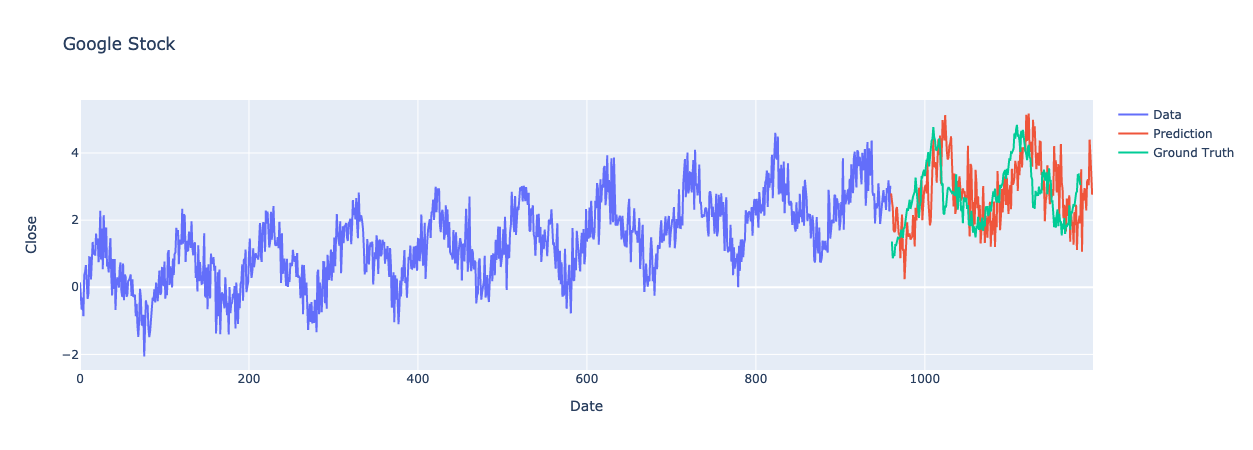

In [103]:
prediction = model.predict_generator(test_generator)

train_data = train_data.reshape((-1))
test_data = test_data.reshape((-1))
prediction = prediction.reshape((-1))


trace1 = go.Scatter(x=train_index, y=train_data, mode="lines", name="Data")
trace2 = go.Scatter(x=test_index, y=test_data, mode="lines", name="Prediction")
trace3 = go.Scatter(x=test_index, y=prediction, mode="lines", name="Ground Truth")
layout = go.Layout(
    title="Google Stock", xaxis={"title": "Date"}, yaxis={"title": "Close"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()




Using TensorFlow backend.


1308
328
Epoch 1/25
65/65 [==============================] - 2s 33ms/step - loss: 678899.2230
Epoch 2/25
65/65 [==============================] - 1s 14ms/step - loss: 646367.1730
Epoch 3/25
65/65 [==============================] - 1s 14ms/step - loss: 618715.3928
Epoch 4/25
65/65 [==============================] - 1s 14ms/step - loss: 582864.9017
Epoch 5/25
65/65 [==============================] - 1s 14ms/step - loss: 587527.9754
Epoch 6/25
65/65 [==============================] - 1s 14ms/step - loss: 592342.2077
Epoch 7/25
65/65 [==============================] - 1s 14ms/step - loss: 577040.9899
Epoch 8/25
65/65 [==============================] - 1s 14ms/step - loss: 556907.6757
Epoch 9/25
65/65 [==============================] - 1s 14ms/step - loss: 532326.3471
Epoch 10/25
65/65 [==============================] - 1s 14ms/step - loss: 502057.1528
Epoch 11/25
65/65 [==============================] - 1s 14ms/step - loss: 465379.3715
Epoch 12/25
65/65 [==============================] - 1

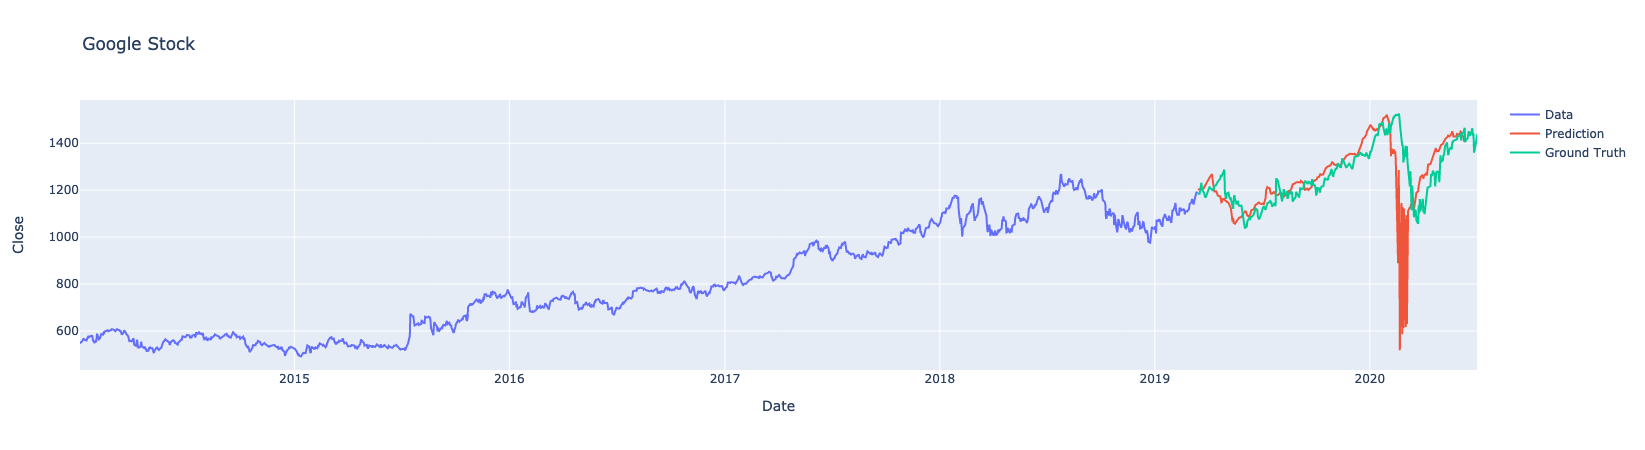

In [23]:

import pandas as pd
import numpy as np
import keras
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense
from pandas_datareader import data
import os
import plotly.express as px


os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

start_date = "2014-01-01"
end_date = "2020-07-01"
SRC_DATA_FILENAME = "goog_data.pkl"

try:
    goog_data = pd.read_pickle(SRC_DATA_FILENAME)
except FileNotFoundError:
    goog_data = data.DataReader("GOOG", "yahoo", start_date, end_date)
    goog_data.to_pickle(SRC_DATA_FILENAME)


df = goog_data
df["Date"] = df.index

close_data = df["Close"].values
close_data = close_data.reshape((-1, 1))

split_percent = 0.80
split = int(split_percent * len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

date_train = df["Date"][:split]
date_test = df["Date"][split:]

print(len(close_train))
print(len(close_test))

look_back = 15

train_generator = TimeseriesGenerator(
    close_train, close_train, length=look_back, batch_size=20
)
test_generator = TimeseriesGenerator(
    close_test, close_test, length=look_back, batch_size=1
)

from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(10,  activation="relu", input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")

num_epochs = 25
model.fit_generator(train_generator, epochs=num_epochs, verbose=1)

prediction = model.predict_generator(test_generator)

close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))

lose_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))


trace1 = go.Scatter(x=date_train, y=close_train, mode="lines", name="Data")
trace2 = go.Scatter(x=date_test, y=prediction, mode="lines", name="Prediction")
trace3 = go.Scatter(x=date_test, y=close_test, mode="lines", name="Ground Truth")
layout = go.Layout(
    title="Google Stock", xaxis={"title": "Date"}, yaxis={"title": "Close"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()




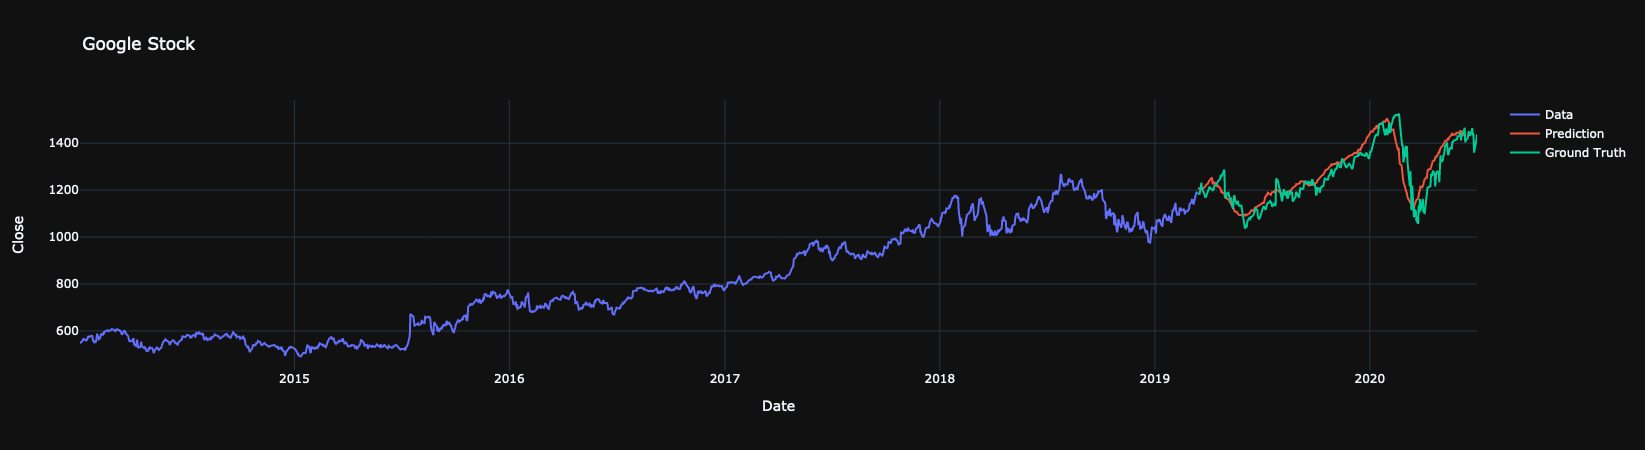

In [3]:
trace1 = go.Scatter(x=date_train, y=close_train, mode="lines", name="Data")
trace2 = go.Scatter(x=date_test, y=prediction, mode="lines", name="Prediction")
trace3 = go.Scatter(x=date_test, y=close_test, mode="lines", name="Ground Truth")
layout = go.Layout(
    title="Google Stock", xaxis={"title": "Date"}, yaxis={"title": "Close"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.update_layout(template='plotly_dark')
fig.show()

In [9]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


In [24]:
print(tf.__version__)

2.0.0
